In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import loadTDT as tdt
from scipy import signal
from scipy.signal import detrend
import statsmodels.formula.api as smf
from scipy.signal import resample
from scipy.signal import medfilt
from scipy.signal import butter
from scipy.signal import filtfilt
from statsmodels import robust
from scipy import ndimage, misc
from scipy.stats import levene, ttest_ind
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import tdt as tdt2
import pickle
sns.set_context("poster")

## Analysis for dopaminergic neural recordings during the social interaction test

In [4]:
raw_data = pickle.load( open( "si_recording.p", "rb" ) )

In [20]:
SI_df = pd.read_csv('SI.csv')

In [10]:
"""
Filtering functions for photometry
"""
def butter_bandpass(lowcut, highcut, fs=1017, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs=1017, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def butter_lowpass(cutoff, fs=1017, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs=1017, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs=1017, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs=1017, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def filter_raw(raw_signal,fs=1017):
    sig2 = butter_lowpass_filter(raw_signal,10,fs,order=3) # 10 hz
    sig3= butter_highpass_filter(sig2,0.1,fs,order=3)     # 0.05 hz
    hp = butter_highpass_filter(raw_signal,30,fs,order=3)
    return sig3


def new_fp_peaks(raw_signal,fs=1017):
    sig2 = butter_lowpass_filter(raw_signal,10,fs,order=3)
    sig3= butter_highpass_filter(sig2,0.1,fs,order=3)
    hp = butter_highpass_filter(raw_signal,4,fs,order=3)
    limit = np.max([ndimage.maximum_filter(-hp,fs)*2,ndimage.maximum_filter(sig3/np.std(hp),int(601/1017*fs))],axis=0)
    peaks = np.where(np.logical_and(sig3/np.std(hp)>=limit,sig3/np.std(hp)>2.5))[0]
    return peaks

def moving_average(a, n=1017*10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:]=ret[n - 1:] / n
    ret[:n-1]=a[:-1].mean()
    return ret

def filter_downsample(s,fs=1017,downsampled=120):
    fp1 = butter_lowpass_filter(s,30,fs=fs,order=3)
    fp = butter_highpass_filter(fp1,0.1,fs,order=3)
    ts = (fp-np.mean(fp))/np.std(fp)
    return ts

In [98]:
females = {415, 417, 422, 423, 424, 433, 434}
controls = {330,331,347,348,337,355,58,600,360,361,37,38,35,36,33,34,54,55,10,12,303,302,416,425,430,431}
BAD = {425,426,13,335,353,59,30,346,313,337,70,432,29,392,377,12,335,353,59,13,425,426,30,600}
fs=1017

In [99]:
raw_data.keys()

dict_keys([10, 11, 12, 13, 54, 55, 60, 61, 70, 71, 392, 29, 30, 32, 37, 38, 40, 41, 42, 58, 59, 600, 360, 361, 362, 363, 364, 375, 376, 377, 301, 312, 302, 303, 313, 314, 425, 426, 415, 417, 416, 422, 423, 424, 432, 430, 433, 434, 431])

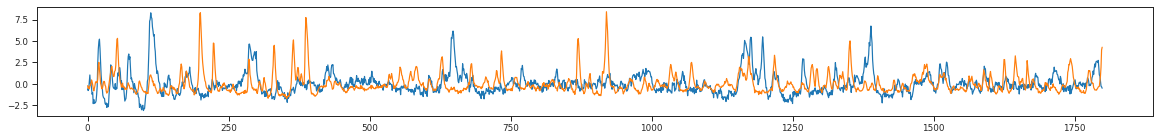

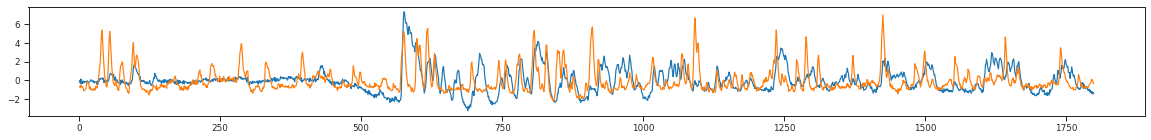

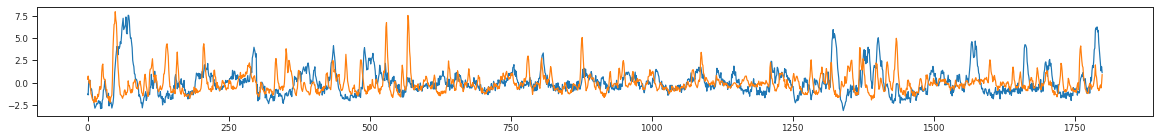

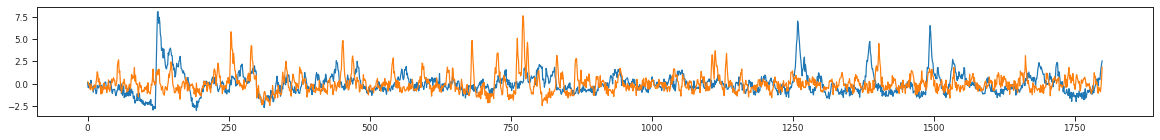

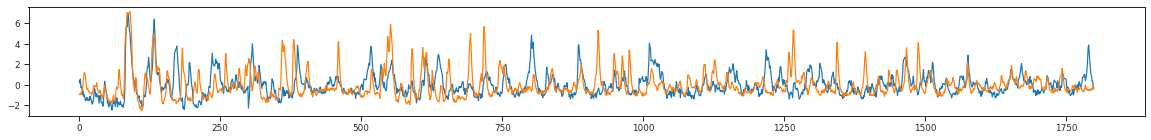

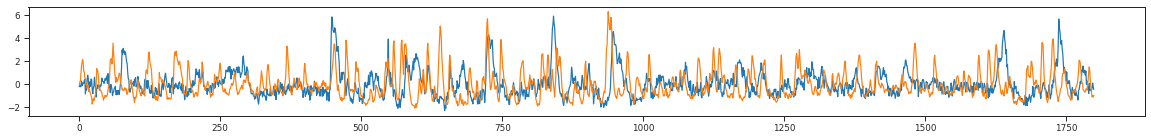

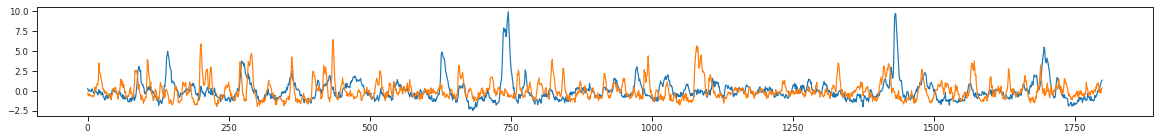

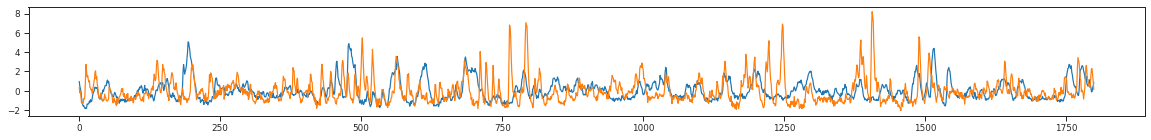

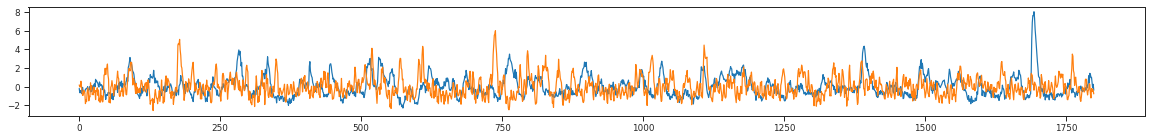

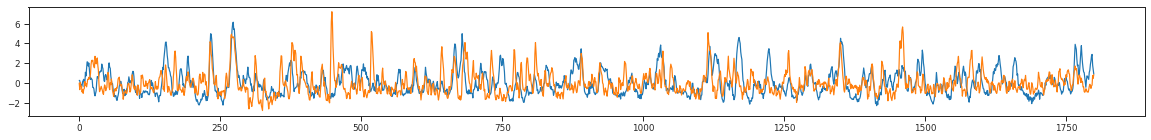

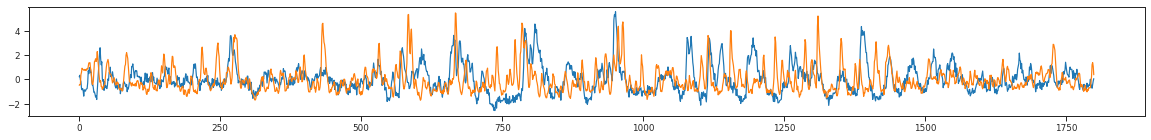

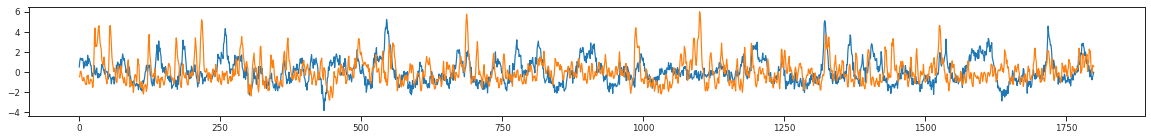

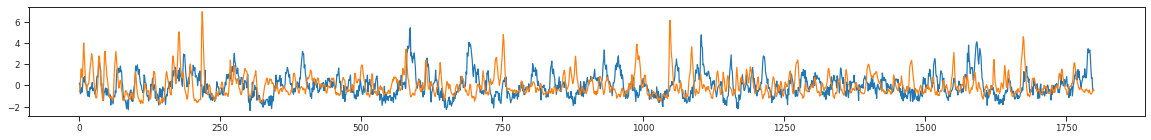

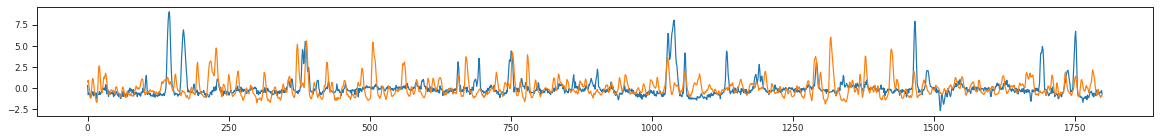

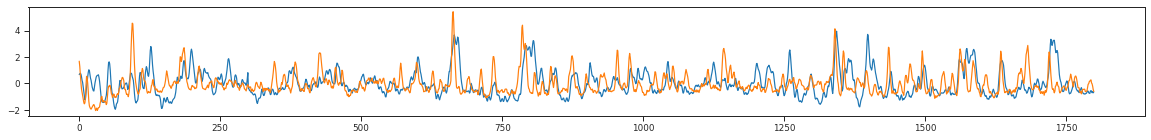

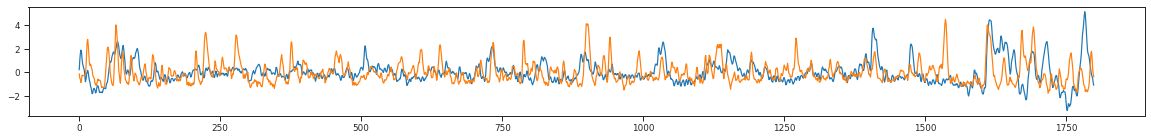

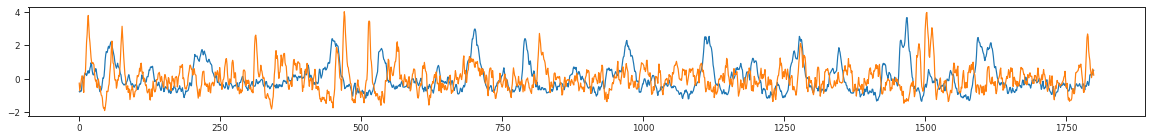

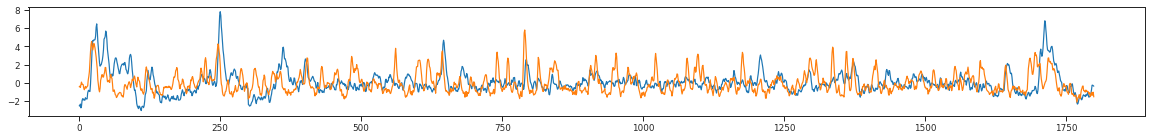

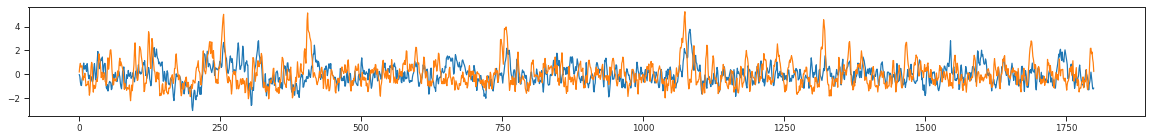

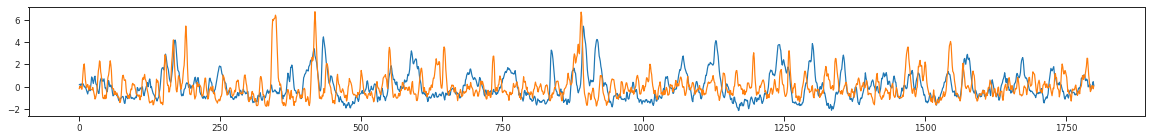

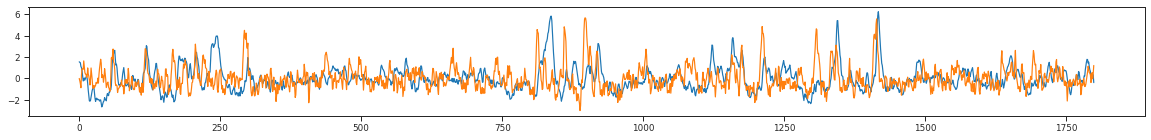

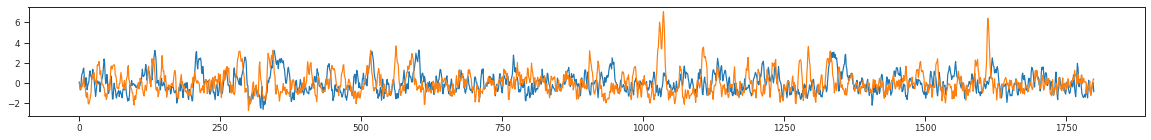

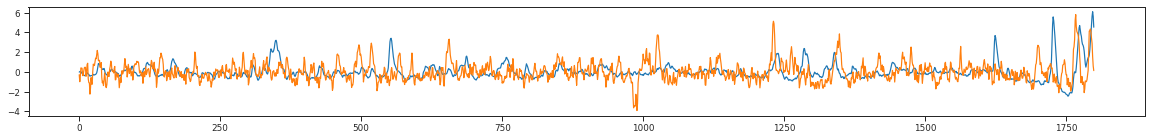

In [100]:
mouse_distance_nac_ts={'m':[],'d':[],'n':[],'t':[],'dc':[],'sex':[]}

for m,dat in raw_data.items():
    if m not in females and (m in BAD or m in controls):
        continue
    n=[]
    
    sig = dat['nac']
    gcamp = filter_downsample(sig/moving_average(sig))
    n_full=gcamp/gcamp.std()
    n=n_full[np.linspace(0,len(n_full)-1,len(dat['s_zone'])).astype(int)]
    plt.figure(figsize=(20,2))
    plt.plot(n[:30*60])
    
    t=[]
    sig = dat['ts']
    gcamp = filter_downsample(sig/moving_average(sig))
    t_full=gcamp/gcamp.std()
    t=t_full[np.linspace(0,len(t_full)-1,len(dat['s_zone'])).astype(int)]
    plt.plot(t[:30*60])
    plt.show()

    mouse_distance_nac_ts['m'].append(m)
    mouse_distance_nac_ts['d'].append(dat['s_zone'].astype('int')*-1*30+30)
    mouse_distance_nac_ts['dc'].append(dat['o_zone'].astype('int')*-1*30+30)
    mouse_distance_nac_ts['n'].append(n)
    mouse_distance_nac_ts['t'].append(t)
    if m in females:
        mouse_distance_nac_ts['sex'].append('F')
    else:
        mouse_distance_nac_ts['sex'].append('M')

In [101]:
set(mouse_distance_nac_ts['m'])

{11,
 32,
 40,
 41,
 42,
 60,
 61,
 71,
 301,
 312,
 314,
 362,
 363,
 364,
 375,
 376,
 415,
 417,
 422,
 423,
 424,
 433,
 434}

11


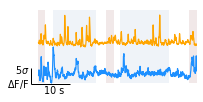

60


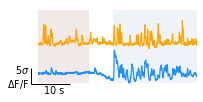

61


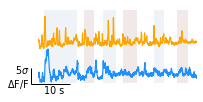

71


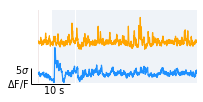

32


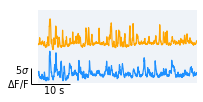

40


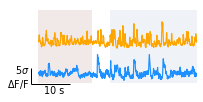

41


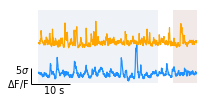

42


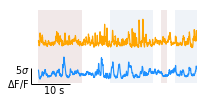

362


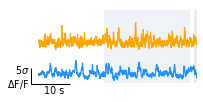

363


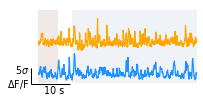

364


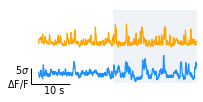

375


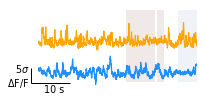

376


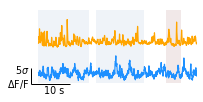

301


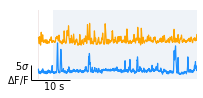

312


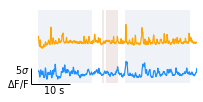

314


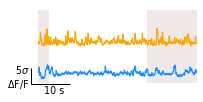

415


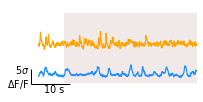

417


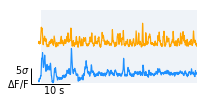

422


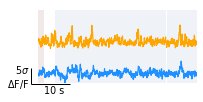

423


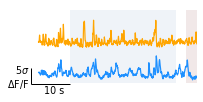

424


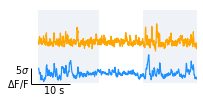

433


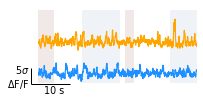

434


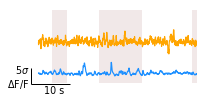

In [107]:
from matplotlib.patches import Rectangle
sns.set_context('paper')
import numpy as np
ns=[]
ts=[]
npe=[]
tp=[]
nps=[]
tps=[]
npo=[]
tpo=[]
nme=[]
tm=[]
nms=[]
tms=[]
nmo=[]
tmo=[]

ns_off=[]
ts_off=[]
n_si=[]
t_si=[]
ns_r=[]
ns_s=[]
ts_r=[]
ts_s=[]
sex=[]
THRESH=15
WINDOW=2*30
for m,d,d2,t,n in zip(mouse_distance_nac_ts['m'],
                   mouse_distance_nac_ts['d'],
                      mouse_distance_nac_ts['dc'],
                mouse_distance_nac_ts['t'],
                mouse_distance_nac_ts['n']):

    resilience=SI_df.query('mouse==%d'%m).resilience.values[0]
    si=SI_df.query('mouse==%d'%m).SI_time.values[0]
    print(m)
    fig,ax=plt.subplots(1,1,figsize=(3,1.5))

    plt.plot(np.array(n)+10,color='dodgerblue')
    plt.plot(np.array(t)+20,color='orange')

    ## object
    d_filt=medfilt(d2,11)
    d_o=d_filt.copy()
    onsets=np.where(np.logical_and(d_filt[:-1]>THRESH,d_filt[1:]<=THRESH))[0]
    sparse_onsets=[o for o in onsets if o>WINDOW and o<len(d_filt)-WINDOW and np.sum(d_filt[o-WINDOW:o-1]<THRESH)==0]
    offsets=np.where(np.logical_and(d_filt[1:]>THRESH,d_filt[:-1]<THRESH))[0]
    sparse_offsets=[o for o in offsets if o>WINDOW and o<len(d_filt)-WINDOW and np.sum(d_filt[o+1:o+WINDOW]<THRESH)==0]
    if d_filt[0]<THRESH:
        sparse_onsets_plt_o=[0]+list(onsets)
    else:
        sparse_onsets_plt_o=onsets
    if d_filt[-1]<THRESH:
        sparse_offsets_plt_o=list(offsets)+[len(d_filt)-1]
    else:
        sparse_offsets_plt_o=offsets

    for on, off in zip(sparse_onsets_plt_o,sparse_offsets_plt_o):
        ax.add_patch( Rectangle((on, 7),
                        off-on, 23,
                        fc ='rosybrown', 
                        ec ='none',
                        lw = 0,
                               alpha=0.2) )
    
    d_filt=medfilt(d,11)
    d_s=d_filt.copy()
    onsets=np.where(np.logical_and(d_filt[:-1]>THRESH,d_filt[1:]<=THRESH))[0]
    sparse_onsets=[o for o in onsets if o>WINDOW and o<len(d_filt)-WINDOW and np.sum(d_filt[o-WINDOW:o-1]<THRESH)==0]
    offsets=np.where(np.logical_and(d_filt[1:]>THRESH,d_filt[:-1]<THRESH))[0]
    sparse_offsets=[o for o in offsets if o>WINDOW and o<len(d_filt)-WINDOW and np.sum(d_filt[o+1:o+WINDOW]<THRESH)==0]
    if d_filt[0]<THRESH:
        sparse_onsets_plt=[0]+list(onsets)
    else:
        sparse_onsets_plt=onsets
    if d_filt[-1]<THRESH:
        sparse_offsets_plt=list(offsets)+[len(d_filt)-1]
    else:
        sparse_offsets_plt=list(offsets)

    for on, off in zip(sparse_onsets_plt,sparse_offsets_plt):
        ax.add_patch( Rectangle((on, 7),
                        off-on, 23,
                        fc ='lightsteelblue', 
                        ec ='none',
                        lw = 0,
                               alpha=0.2) )
        
        
    plt.xticks(30*60*np.arange(5),np.arange(5))
    plt.yticks([])
    plt.xlim(-70,1200)
    plt.vlines(x=-60,ymin=6.5,ymax=11.5,color='k',linewidth=1)
    plt.axis('off')
    plt.hlines(y=6.5,xmin=-60,xmax=8*30,color='k',linewidth=1)
    plt.text(-68,9,'5$\sigma$\n$\Delta$F/F',va='center',ha='right',color='k')
    plt.text(4*30,4.7,'10 s',va='center',ha='center',color='k')

    plt.show()        
        
    n2=[]
    t2=[]
    
    for s in sparse_onsets:
        if len(n):
            n2.append(n[s-WINDOW:s+WINDOW])
        if len(t):
            t2.append(t[s-WINDOW:s+WINDOW])
            
    n2=np.mean(n2,axis=0)
    t2=np.mean(t2,axis=0)
    if len(n):
        ns.append(n2)
        n_si.append(si)
        if resilience=="resilient":
            ns_r.append(n2)
        elif resilience=="susceptible":
            ns_s.append(n2)
    if len(t):
        ts.append(t2)
        t_si.append(si)
        if resilience=="resilient":
            ts_r.append(t2)
        elif resilience=="susceptible":
            ts_s.append(t2)
            
    if m in females:
        sex.append('F')
    else:
        sex.append('M')
    
    onsets=np.where(np.logical_and(d_filt[1:]>THRESH,d_filt[:-1]<THRESH))[0]
    sparse_onsets=[o for o in onsets if o>WINDOW and o<len(d_filt)-WINDOW and np.sum(d_filt[o+1:o+WINDOW]<15)==0]
    n2=[]
    t2=[]
    for s in sparse_onsets:
        if len(n):
            n2.append(n[s-WINDOW:s+WINDOW])
        if len(t):
            t2.append(t[s-WINDOW:s+WINDOW])
    n2=np.mean(n2,axis=0)
    t2=np.mean(t2,axis=0)
    if len(n):
        ns_off.append(n2)
        ptest=new_fp_peaks(n,30)
        not_in_either=np.logical_and(d_s>=THRESH,d_filt>=THRESH)
        npe.append(np.sum(not_in_either[ptest])/np.sum(not_in_either)*30*60)
        nps.append(np.sum(d_s[ptest]<THRESH)/np.sum(d_s<THRESH)*30*60)
        npo.append(np.sum(d_o[ptest]<THRESH)/np.sum(d_o<THRESH)*30*60)
    if len(t):
        ts_off.append(t2)
        ptest=new_fp_peaks(t,30)
        not_in_either=np.logical_and(d_s>=THRESH,d_filt>=THRESH)
        tp.append(np.sum(not_in_either[ptest])/np.sum(not_in_either)*30*60)
        tps.append(np.sum(d_s[ptest]<THRESH)/np.sum(d_s<THRESH)*30*60)
        tpo.append(np.sum(d_o[ptest]<THRESH)/np.sum(d_o<THRESH)*30*60)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


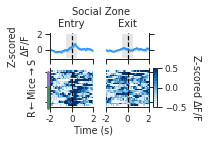

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


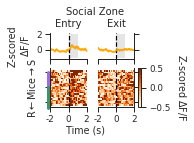

In [108]:
n_si_together=n_si
ns_together=ns
ns_off_together=ns_off
t_si_together=t_si
ts_together=ts
ts_off_together=ts_off


import scipy
from matplotlib import patches
sns.set_context("paper")
sns.set_style("ticks",{
    'legend.title':''
})
ggp=np.array([[0.22953434, 0.57685998, 0.42976558, 1.        ],
       [0.57609486, 0.42953354, 0.90002989, 1.        ],
        [0.133     , 0.133     , 0.133     , 1.        ]])
cols={'VTA-NAc':"Blues",
     'SN-TS':'Oranges'}
linecols={'VTA-NAc':'dodgerblue',
        'SN-TS':'orange'}
onoff_titles=['Entry','Exit']

sizes=[(2.3,2),
      (2.1,2)]
for i,region in enumerate(['VTA-NAc','SN-TS']):
    fig,axs=plt.subplots(nrows=2,ncols=2,figsize=sizes[i],sharex=True,sharey='row',gridspec_kw={
                           'width_ratios': [1, 1],
                           'height_ratios': [1, 1.5]})
    im2s=[]
    for j,onoff in enumerate(['onset','offset']):

        side=int(onoff=='offset')
        sns.set_context("paper")
        sns.set_style('white')

        query='group=="GCaMP" and region=="%s" and onoff=="%s"'%(region,onoff)
        
        im=np.array(ns_together)[np.argsort(n_si_together),:]

        if j:
            im = np.array(ns_off_together)[np.argsort(n_si_together),:]

        if i:
            im=np.array(ts_together)[np.argsort(n_si_together),:]
            if j:
                im=np.array(ts_off_together)[np.argsort(n_si_together),:]
        im2=axs[1][j].imshow(im,aspect='auto',cmap=cols[region],vmin=-0.5,vmax=0.5,
                            interpolation='None')

        im2s.append(im2)
        axs[1][j].set_xticks([0,60,119])
        axs[1][j].set_xticklabels([-2,0,2])
        axs[1][j].set_yticks([tick for tick in axs[1][j].get_yticks() if tick>=0])

        axs[1][j].set_ylim(len(im),-int(len(im))/10)

        axs[1][j].plot((60,60),(0,len(im)),linestyle='--',color='k')
        axs[0][j].axvline(x=60,linestyle='--',color='black')
        axs[0][j].set_title(onoff_titles[j],fontsize=10)

        for k in range(2):
            sns.despine(ax=axs[k][1])#,right=False,left=True)
            axs[k][1].spines['left'].set_visible(False)
            axs[k][1].spines['right'].set_visible(True)
            axs[k][1].yaxis.tick_right()
            axs[k][0].yaxis.tick_left()
            axs[k][0].xaxis.tick_bottom()
            axs[k][1].xaxis.tick_bottom()
            sns.despine(ax=axs[k][0])

        axs[1][1].set_yticklabels([])
        axs[1][0].set_ylabel('Mice')
        axs[0][0].set_ylabel('Z-scored\n%s $\Delta$F/F'%region)
        plt.suptitle('Social Zone',size=10,va='top',ha='left',y=0.88,x=0.45)
        
        means=np.mean(np.array(im),axis=0)
        sterrs=scipy.stats.sem(np.array(im),axis=0)
        axs[0][j].plot(means,color=linecols[region])
        axs[0][j].fill_between(np.arange(len(means)),
                               means-sterrs,
                               means+sterrs,
                               color=linecols[region],
                              alpha=0.5)
        
        if i==0:
            rect = patches.Rectangle((45,-1),30,3,linewidth=0,
                             alpha=0.2,facecolor='grey')
        else:
            rect = patches.Rectangle((60,-1),30,3,linewidth=0,
                             alpha=0.2,facecolor='grey')
        axs[0][j].add_patch(rect)

    axs[1][1].set_yticklabels([])
    axs[1][0].set_ylabel(r'R$\leftarrow$Mice$\rightarrow$S')
    axs[0][0].set_ylabel('Z-scored\n$\Delta$F/F')
    trans = axs[1][0].get_yaxis_transform()

    axs[1][0].plot([-0.05,-0.05],[0,10], color=ggp[1], transform=trans, clip_on=False,linewidth=3)
    axs[1][0].plot([-0.05,-0.05],[10,24], color=ggp[0], transform=trans, clip_on=False,linewidth=3)
    
        
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbar_ax = inset_axes(axs[1][1],
               width="8%",  # width = 5% of parent_bbox width
               height="100%",  # height : 50%
               loc='lower left',
               bbox_to_anchor=(1.1, 0., 1, 1),
               bbox_transform=axs[1][1].transAxes,
               borderpad=0,
               )
    cbar=fig.colorbar(im2s[1], cax=cbar_ax,ticks=[-0.5, 0, 0.5,1])
    cbar.set_label('Z-scored $\Delta$F/F',rotation=-90,va='bottom')
    fig.text(0.58, 0.0, 'Time (s)', ha='center')
#     fig.text(-0.02, 0.5, r'Mice', va='center', rotation='vertical')

    plt.tight_layout(pad=1,h_pad=2) 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass

    plt.show()


In [109]:

onoff=['onset']*len(ns)+['offset']*len(ns)
resilience=list(np.array(n_si)>42)*2

d = pd.DataFrame({'si':list(n_si)*2,
              'resilience':resilience,
              'nac':list(np.mean(np.array(ns)[:,45:75],axis=1))+list(np.mean(np.array(ns_off)[:,45:75],axis=1)),
              'sex':list(sex)*2,
              'onoff':onoff})

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

0.5081082542176273 0.013308316543480156


/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

-0.3827787555285387 0.07142874529076576


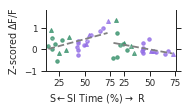

In [110]:
sex2size = {'M':12,
             'F':15}
sex2marker = {'M':'o',
             'F':'^'}

r2color = {True:ggp[1],
          False:ggp[0]}

fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(2.7,1.6),sharey=True)
sns.set_context('paper')
sns.set_style('ticks')

for i,onoff in enumerate(['onset','offset']):
    for sex in ['M','F']:
        for r in [True,False]:
            d_r = d.query('onoff=="%s" and sex=="%s" and resilience==%d'%(onoff, sex,r))
            sns.regplot(d_r.si,d_r.nac,
                        scatter_kws={'s':sex2size[sex]},
                        color=r2color[r],ci=0,
                        line_kws={'linewidth':0,
                                  'color':'white'},
                        ax=axs[i],
                       marker=sex2marker[sex])
    d_onoff = d.query('onoff=="%s"'%onoff)
    sns.regplot(d_onoff.si,d_onoff.nac,
                ci=0,scatter_kws={'s':0},
                line_kws={'linestyle':'--',
                          'color':'grey'},
                ax=axs[i])
    r,p = scipy.stats.pearsonr(d_onoff.si,d_onoff.nac)
    print(r,p)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')


axs[0].set_ylabel('Z-scored $\Delta$F/F')
plt.xlabel(r'S$\leftarrow$SI Time (%)$\rightarrow$ R',x=-0.2)

axs[0].set_ylim(-1,1.8)
sns.despine()
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(True)
axs[1].yaxis.tick_right()
axs[0].yaxis.tick_left()
axs[0].xaxis.tick_bottom()
axs[1].xaxis.tick_bottom()

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.3)
plt.show()